# ASR Using Conformer: Convolution-augmented Transformer

+ https://arxiv.org/abs/2005.08100
+ Dataset: https://github.com/getalp/ALFFA_PUBLI...
+ Librosa: https://librosa.org/doc/latest/index....
+ Z-score normalization: https://www.geeksforgeeks.org/data-an...
+ Mel spectrogram/short-time fourier transform (STFT): https://www.mathworks.com/help/signal...
+ Mel frequency cepstral coefficients (MFCCs): http://practicalcryptography.com/misc...
+ Discrete cosine transform (DCT): https://www.mathworks.com/help/images...
+ Unicode data: https://www.ssec.wisc.edu/~tomw/java/...
+ Padding function: https://docs.pytorch.org/docs/stable/...
+ DeepSpeech2: https://arxiv.org/pdf/1512.02595
+ 1D Convolution: https://e2eml.school/convolution_one_...
+ Gated Recurrent Units (GRUs):   / understanding-gated-recurrent-unit-gru-in-...  , https://www.geeksforgeeks.org/machine..., + + + https://en.wikipedia.org/wiki/Gated_r...
+ Activation functions: https://www.geeksforgeeks.org/machine...
+ Model output shape formula: https://docs.pytorch.org/docs/stable/...
+ Connectionist Temporal Classification (CTC) Loss:
+ https://distill.pub/2017/ctc/
+ Wav2Vec2.0: https://arxiv.org/pdf/2006.11477
+ Character Error Rate (CER): https://galileo.ai/blog/character-err...
+ Thumbnail: https://developer.nvidia.com/blog/how...
+ MelaNet (inspiration): https://github.com/tilayealemu/MelaNet
+ Another ASR (large model but also inspiration): https://github.com/10acad-group3/spee...
+ General Machine Learning (inspiration for video style):    / @andrejkarpathy  


## Import libs

In [1]:
# Block 0: imports & config
from __future__ import annotations
import os, math, random, unicodedata, pathlib
from dataclasses import dataclass
from typing import List, Tuple, Optional, Sequence
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

import regex as re
from khmerspeech import (
  normalize,
  datetime as km_datetime,
  phone_numbers,
  currency,
  cardinals,
  decimals,
  urls,
  ordinals,
  dict_verbalize,
  repeater,
  punctuations,
  parenthesis
)

# Repro
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@dataclass
class Config:
    # Data
    data_tsv: str = "/home/metythorn/konai/services/asr-service/data/khmerasr-data-v1.txt"
    train_split: float = 0.9

    # Audio/feature
    sample_rate: int = 16000
    n_fft: int = 400
    hop_length: int = 160
    n_mels: int = 80

    # Model (DS2 small)
    conv_channels1: int = 32
    conv_channels2: int = 64
    conv_kernel: Tuple[int,int] = (11, 5)
    conv_stride: Tuple[int,int] = (2, 2)   # used twice -> time downsample ~4x
    conv_padding: Tuple[int,int] = (5, 2)

    rnn_hidden: int = 256
    rnn_layers: int = 3
    rnn_bidirectional: bool = True   # set False for streaming
    dropout: float = 0.1

    # Training
    batch_size: int = 8
    lr: float = 1e-3
    epochs: int = 5
    grad_clip: float = 1.0

CFG = Config()

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["axes.grid"] = True


## Load Dataset

In [2]:
def normalize_khmer(text: str) -> str:
    text = normalize.processor(text)
    text = phone_numbers.processor(text, chunk_size=3)
    text = km_datetime.date_processor(text)
    text = km_datetime.time_processor(text)
    text = urls.processor(text)
    text = repeater.processor(text)
    text = currency.processor(text)
    text = cardinals.processor(text)
    text = decimals.processor(text)
    text = ordinals.processor(text)
    text = punctuations.processor(text)
    text = dict_verbalize(text)
    text = re.sub(r"\s+", " ", text.strip())
    
    return text

def load_dataset_tsv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, sep="\t", names=["audio_path", "transcript"], dtype=str)
    df = df.dropna(subset=["audio_path", "transcript"])
    df["audio_path"] = df["audio_path"].str.strip()
    df["transcript"] = df["transcript"].map(normalize_khmer)
    df = df[(df["audio_path"] != "") & (df["transcript"] != "")]
    df["audio_path"] = df["audio_path"].apply(lambda p: str(pathlib.Path(p).expanduser().resolve()))
    exists = df["audio_path"].apply(lambda p: pathlib.Path(p).exists())
    if (~exists).sum():
        print(f"Skipped {(~exists).sum()} rows with missing audio")
    return df[exists].reset_index(drop=True)

df = load_dataset_tsv(CFG.data_tsv)
print("Rows:", len(df))
df.head()



Skipped 99 rows with missing audio
Rows: 152396


,audio_path,transcript
0,/home/metythorn/konai/services/speech-service/...,ចិតសិបប្រាំ▁ដុល្លារ ប្រាំ សេន សូមផ្ញើទៅលេខ សូន...
1,/home/metythorn/konai/services/speech-service/...,សែសិបប្រាំមួយ▁ដុល្លារ ប្រាំ សេន សូមផ្ញើទៅលេខ ស...
2,/home/metythorn/konai/services/speech-service/...,ម្ភៃបួន▁ដុល្លារ សាមសិប សេន សូមបញ្ជូនចូលលេខនេះ ...
3,/home/metythorn/konai/services/speech-service/...,សែសិប▁ដុល្លារ ហាសិប សេន សូមបញ្ចូនទៅ សូន្យ▁ហុកស...
4,/home/metythorn/konai/services/speech-service/...,សាមសិបពីរ▁ដុល្លារ សាមសិប សេន សូមបញ្ចូលលុយទៅ សូ...


In [3]:
df.tail(20)

,audio_path,transcript
152376,/home/metythorn/konai/services/speech-service/...,ឃុំ ស្រឡៅ ស្រុក តាំង គោក ខេត្ត កំពង់ធំ រូបថត
152377,/home/metythorn/konai/services/speech-service/...,ភ្ញៀវ ទេសចរ ជម្លៀស ខ្លួន ចេញ
152378,/home/metythorn/konai/services/speech-service/...,ពី រថយន្ត ដែល ជាប់គាំង ក្នុង ព្រឹល
152379,/home/metythorn/konai/services/speech-service/...,ក្រាស់ រូបថត
152380,/home/metythorn/konai/services/speech-service/...,មៀន ប៉ៃលិន កម្ពុជា ជួប បញ្ហា ទីផ្សារ នាំចេញ
152381,/home/metythorn/konai/services/speech-service/...,ទៅកាន់ ប្រទេស ថៃ រូបថត សហការី
152382,/home/metythorn/konai/services/speech-service/...,លេខាធិការ ផែនការ សេដ្ឋកិច្ច លោក រូបថត
152383,/home/metythorn/konai/services/speech-service/...,កវី ស្រី ស្រស់ សោភាកញ្ញា លឹម ផាន់ ណា
152384,/home/metythorn/konai/services/speech-service/...,រូប ហ្វេសប៊ុក
152385,/home/metythorn/konai/services/speech-service/...,ជម្លោះ ពាណិជ្ជកម្ម រវាង អាមេរិក និង ចិន ដែល កំ...


In [4]:
df["transcript"].to_csv('clean_transcript.csv', index=False, encoding='utf-8-sig')

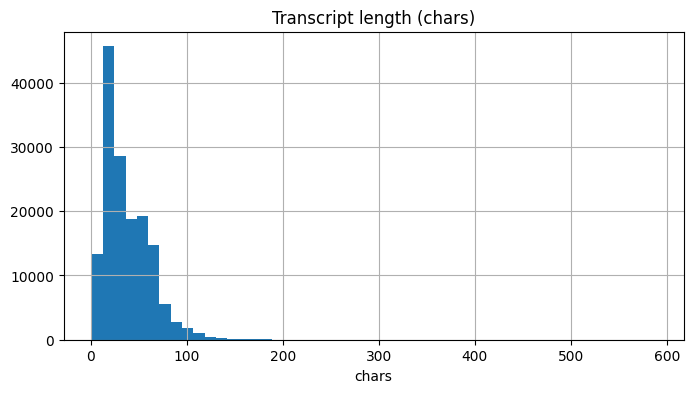

In [11]:
# Transcript length plot
df["char_len"] = df["transcript"].apply(len)
plt.hist(df["char_len"], bins=50)
plt.title("Transcript length (chars)")
plt.xlabel("chars")
plt.show()

In [15]:
df["char_len"].describe()

count    152396.000000
mean         37.462821
std          23.979648
min           1.000000
25%          18.000000
50%          32.000000
75%          53.000000
max         588.000000
Name: char_len, dtype: float64

In [22]:
import numpy as np, json, subprocess, shutil, torchaudio

def get_duration_sec(path: str) -> float:
    if shutil.which("ffprobe"):
        try:
            out = subprocess.check_output(
                ["ffprobe","-v","error","-print_format","json","-show_streams","-show_format",path],
                stderr=subprocess.STDOUT,
            )
            info = json.loads(out)
            # Prefer stream duration if present
            dur = None
            for s in info.get("streams", []):
                if "duration" in s:
                    dur = float(s["duration"])
                    break
            if dur is None:
                dur = float(info.get("format", {}).get("duration", "nan"))
            if np.isfinite(dur):
                return float(dur)
        except Exception:
            pass

    return np.nan


# durations = df["audio_path"].apply(get_duration_sec)
# df["duration_s"] = durations

# valid = df["duration_s"].dropna()
# print(f"Durations OK: {len(valid)} / {len(df)}")
# if len(valid):
#     plt.hist(valid, bins=50)
#     plt.title("Audio duration (sec)")
#     plt.xlabel("seconds")
#     plt.show()
# else:
#     print("Still no durations — likely all files use a codec not supported by your runtime. FFmpeg is required.")


In [24]:
# Character frequency (top 40)
from collections import Counter

char_counts = Counter("".join(df["transcript"].tolist()))
top = char_counts.most_common(40)
top

[(' ', 834077),
 ('្', 411236),
 ('ា', 362949),
 ('រ', 318411),
 ('ន', 276032),
 ('ប', 275885),
 ('ក', 190610),
 ('ម', 180791),
 ('ល', 167853),
 ('ស', 163856),
 ('់', 132837),
 ('ី', 130068),
 ('យ', 128373),
 ('ង', 126075),
 ('ត', 121450),
 ('ទ', 111404),
 ('ំ', 111363),
 ('ព', 102850),
 ('ុ', 97806),
 ('ូ', 97430),
 ('ិ', 85499),
 ('ច', 85112),
 ('ួ', 80344),
 ('េ', 69754),
 ('ញ', 60385),
 ('ដ', 58218),
 ('វ', 52839),
 ('ខ', 50867),
 ('អ', 50853),
 ('៉', 47894),
 ('ើ', 46108),
 ('ៅ', 45798),
 ('ជ', 45251),
 ('▁', 44621),
 ('ែ', 42969),
 ('ថ', 41102),
 ('គ', 37906),
 ('ណ', 33950),
 ('ៃ', 33356),
 ('ផ', 32914)]

## Vocab + helpers + greedy CTC

In [30]:
WORD_DELIMITER = "|"
IGNORED_CHARACTERS = [
    "!", "\"", "#", "$", "(", ")", ",", "-", ".", "/", "។", "៕", "៖", "ៗ",
    "០", "១", "២", "៣", "៤", "៥", "៦", "៧", "៨", "៩", "​", "—", "“", "”",
    "취", "[", "]", ":", "?", '…',

    # English uppercase
    'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',

    # English lowercase
    'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
]


def build_vocab(texts: Sequence[str], ignored_chars: Sequence[str] = IGNORED_CHARACTERS) -> List[str]:

    ignored_set = set(ignored_chars)
    all_chars = set()

    for text in texts:
        filtered = [ch for ch in text if ch not in ignored_set]
        all_chars.update(filtered)

    chars = sorted(all_chars)
    vocab = ["<pad>", "<blank>"] + chars
    print(f"Vocab built: {len(vocab)} symbols (ignored {len(ignored_set)} chars)")
    return vocab

VOCAB = build_vocab(df["transcript"].tolist())
VOCAB

Vocab built: 75 symbols (ignored 86 chars)


['<pad>',
 '<blank>',
 ' ',
 'ក',
 'ខ',
 'គ',
 'ឃ',
 'ង',
 'ច',
 'ឆ',
 'ជ',
 'ឈ',
 'ញ',
 'ដ',
 'ឋ',
 'ឌ',
 'ឍ',
 'ណ',
 'ត',
 'ថ',
 'ទ',
 'ធ',
 'ន',
 'ប',
 'ផ',
 'ព',
 'ភ',
 'ម',
 'យ',
 'រ',
 'ល',
 'វ',
 'ស',
 'ហ',
 'ឡ',
 'អ',
 'ឥ',
 'ឦ',
 'ឧ',
 'ឪ',
 'ឫ',
 'ឬ',
 'ឭ',
 'ឮ',
 'ឯ',
 'ឱ',
 'ា',
 'ិ',
 'ី',
 'ឹ',
 'ឺ',
 'ុ',
 'ូ',
 'ួ',
 'ើ',
 'ឿ',
 'ៀ',
 'េ',
 'ែ',
 'ៃ',
 'ោ',
 'ៅ',
 'ំ',
 'ះ',
 'ៈ',
 '៉',
 '៊',
 '់',
 '៌',
 '៍',
 '៎',
 '៏',
 '័',
 '្',
 '▁']

In [31]:
# Block 2: vocab + helpers
def build_vocab(texts: Sequence[str]) -> List[str]:
    chars = sorted(set("".join(texts)))
    return ["<pad>", "<blank>"] + chars

VOCAB = build_vocab(df["transcript"].tolist())
BLANK_IDX = VOCAB.index("<blank>")
IDX2C = VOCAB
C2IDX = {c:i for i,c in enumerate(VOCAB)}

def greedy_ctc_decode(logp: torch.Tensor, blank_idx: int) -> List[List[int]]:
    # logp: (B, T, V)
    pred = logp.argmax(dim=-1)  # (B, T)
    hyps = []
    for seq in pred:
        prev = -1
        out = []
        for idx in seq.tolist():
            if idx != prev and idx != blank_idx:
                out.append(idx)
            prev = idx
        hyps.append(out)
    return hyps

def idx2text(indices: List[int]) -> str:
    return "".join(IDX2C[i] for i in indices if 0 <= i < len(IDX2C))


## Dataset (torchaudio) + collate + feature extractor + a spectrogram plot

In [ ]:
# Block 3: dataset + feature extractor + a mel-spectrogram plot
class ASRDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, vocab: Sequence[str], sr: int):
        self.df = df.reset_index(drop=True)
        self.char_to_idx = {c:i for i,c in enumerate(vocab)}
        self.sr = sr

    def __len__(self): return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        path, text = row["audio_path"], row["transcript"]
        wav, sr = torchaudio.load(path)            # (C, T)
        wav = wav.mean(dim=0) if wav.size(0) > 1 else wav[0]
        if sr != self.sr:
            wav = torchaudio.functional.resample(wav, sr, self.sr)
        wav = wav.clamp(-1, 1)
        label = torch.tensor([self.char_to_idx.get(c, 0) for c in text], dtype=torch.long)
        return wav, text, label

def pad_1d(xs: List[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
    lens = torch.tensor([x.numel() for x in xs], dtype=torch.long)
    T = int(lens.max())
    out = torch.zeros(len(xs), T)
    for i,x in enumerate(xs):
        out[i, :x.numel()] = x
    return out, lens

def collate(batch):
    wavs, texts, labels = zip(*batch)
    wavs, wav_lens = pad_1d(list(wavs))
    return wavs.to(DEVICE), list(texts), list(labels), wav_lens.to(DEVICE)

# Split train/val
n_train = int(len(df) * CFG.train_split)
train_df = df.iloc[:n_train]
val_df   = df.iloc[n_train:]
train_ds = ASRDataset(train_df, VOCAB, CFG.sample_rate)
val_ds   = ASRDataset(val_df,   VOCAB, CFG.sample_rate)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, collate_fn=collate)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=CFG.batch_size, shuffle=False, collate_fn=collate)
print(f"train: {len(train_ds)}, val: {len(val_ds)}")

# Log-Mel extractor (torchaudio)
class LogMelExtractor(nn.Module):
    def __init__(self, sr: int, n_fft: int, hop: int, n_mels: int):
        super().__init__()
        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr, n_fft=n_fft, hop_length=hop, n_mels=n_mels, power=2.0
        )
        self.db = torchaudio.transforms.AmplitudeToDB(stype="power")

    def forward(self, wav: torch.Tensor) -> torch.Tensor:
        # wav: (B, T)
        spec = self.mel(wav)                  # (B, M, Frames)
        logmel = self.db(spec).transpose(1, 2)  # (B, Frames, M)
        return logmel

feat_extractor = LogMelExtractor(CFG.sample_rate, CFG.n_fft, CFG.hop_length, CFG.n_mels).to(DEVICE)

# Plot a spectrogram for one sample
if len(train_ds) > 0:
    w, t, _ = train_ds[0]
    with torch.no_grad():
        mel = feat_extractor(w.unsqueeze(0).to(DEVICE)).squeeze(0).cpu().T  # (M, Frames)
    plt.imshow(mel.numpy(), aspect="auto", origin="lower")
    plt.title("Log-Mel Spectrogram (example)")
    plt.xlabel("frames")
    plt.ylabel("mel bins")
    plt.colorbar()
    plt.show()


## Model Achitecture

In [ ]:
# Block 4: simple DeepSpeech-2 small model (explicit layers & forward)
class DeepSpeech2Small(nn.Module):
    def __init__(self, n_mels: int, vocab_size: int):
        super().__init__()

        # Conv2d frontend
        self.conv1 = nn.Conv2d(1, CFG.conv_channels1, kernel_size=CFG.conv_kernel,
                               stride=CFG.conv_stride, padding=CFG.conv_padding)
        self.bn1   = nn.BatchNorm2d(CFG.conv_channels1)
        self.act1  = nn.ReLU()
        self.do1   = nn.Dropout(CFG.dropout)

        self.conv2 = nn.Conv2d(CFG.conv_channels1, CFG.conv_channels2, kernel_size=CFG.conv_kernel,
                               stride=CFG.conv_stride, padding=CFG.conv_padding)
        self.bn2   = nn.BatchNorm2d(CFG.conv_channels2)
        self.act2  = nn.ReLU()
        self.do2   = nn.Dropout(CFG.dropout)

        # Compute GRU input dim (C * M') using a dummy
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 200, n_mels)  # (B, 1, T, M)
            y = self.conv1(dummy)
            y = self.conv2(y)
            _, C, T2, M2 = y.shape
            self.rnn_in = C * M2

        # GRU stack (Bi-GRU by default)
        self.gru1 = nn.GRU(self.rnn_in, CFG.rnn_hidden, num_layers=1, batch_first=True, bidirectional=CFG.rnn_bidirectional)
        self.ln1  = nn.LayerNorm(CFG.rnn_hidden*(2 if CFG.rnn_bidirectional else 1))
        self.a1   = nn.LeakyReLU()
        self.dg1  = nn.Dropout(CFG.dropout)

        self.gru2 = nn.GRU(self.ln1.normalized_shape[0], CFG.rnn_hidden, num_layers=1, batch_first=True, bidirectional=CFG.rnn_bidirectional)
        self.ln2  = nn.LayerNorm(CFG.rnn_hidden*(2 if CFG.rnn_bidirectional else 1))
        self.a2   = nn.LeakyReLU()
        self.dg2  = nn.Dropout(CFG.dropout)

        self.gru3 = nn.GRU(self.ln2.normalized_shape[0], CFG.rnn_hidden, num_layers=1, batch_first=True, bidirectional=CFG.rnn_bidirectional)
        self.ln3  = nn.LayerNorm(CFG.rnn_hidden*(2 if CFG.rnn_bidirectional else 1))
        self.a3   = nn.LeakyReLU()
        self.dg3  = nn.Dropout(CFG.dropout)

        # CTC head
        out_dim = CFG.rnn_hidden*(2 if CFG.rnn_bidirectional else 1)
        self.fc  = nn.Linear(out_dim, vocab_size)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, M) log-mels
        return: (B, T', V) log-probs for CTC
        """
        # Conv frontend
        x = x.unsqueeze(1)       # (B,1,T,M)
        x = self.conv1(x); x = self.bn1(x); x = self.act1(x); x = self.do1(x)
        x = self.conv2(x); x = self.bn2(x); x = self.act2(x); x = self.do2(x)

        # Flatten per time step
        B, C, T2, M2 = x.size()
        x = x.permute(0,2,1,3).contiguous().view(B, T2, C*M2)  # (B,T',D)

        # GRU stack
        x, _ = self.gru1(x); x = self.ln1(x); x = self.a1(x); x = self.dg1(x)
        x, _ = self.gru2(x); x = self.ln2(x); x = self.a2(x); x = self.dg2(x)
        x, _ = self.gru3(x); x = self.ln3(x); x = self.a3(x); x = self.dg3(x)

        # Head
        x = self.fc(x)
        x = self.log_softmax(x)
        return x


## Training 

In [ ]:
# Block 5: training, validation, plots, sample decodes
model = DeepSpeech2Small(n_mels=CFG.n_mels, vocab_size=len(VOCAB)).to(DEVICE)
criterion = nn.CTCLoss(blank=BLANK_IDX, zero_infinity=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)

def subsampled_lengths(frame_lens: torch.Tensor) -> torch.Tensor:
    # two time strides of 2 -> total factor 4 (ceil)
    return (frame_lens + 3) // 4

def wave_to_feats_and_lens(wavs: torch.Tensor, wav_lens: torch.Tensor):
    feats = feat_extractor(wavs)            # (B, Frames, M)
    frame_lens = torch.full_like(wav_lens, feats.size(1))
    enc_lens = subsampled_lengths(frame_lens)
    return feats, enc_lens

def pack_targets(lbls: List[torch.Tensor]):
    Smax = max(len(x) for x in lbls)
    out = torch.zeros(len(lbls), Smax, dtype=torch.long, device=DEVICE)
    lens = torch.tensor([len(x) for x in lbls], dtype=torch.long, device=DEVICE)
    for i,t in enumerate(lbls):
        out[i,:len(t)] = t.to(DEVICE)
    return out, lens

train_losses, val_losses = [], []

def train_one_epoch(epoch: int):
    model.train()
    total = 0.0
    for wavs, texts, labels, wav_lens in train_loader:
        optimizer.zero_grad()
        feats, enc_lens = wave_to_feats_and_lens(wavs, wav_lens)
        logp = model(feats)                              # (B, T', V)
        logp_tnc = logp.permute(1,0,2)                   # (T', B, V)
        targets, target_lens = pack_targets(labels)
        loss = criterion(logp_tnc, targets, enc_lens, target_lens)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.grad_clip)
        optimizer.step()
        total += loss.item()
    avg = total / max(1, len(train_loader))
    train_losses.append(avg)
    print(f"Epoch {epoch} | train loss: {avg:.4f}")

@torch.no_grad()
def validate(epoch: int):
    model.eval()
    total = 0.0
    samples = []
    for wavs, texts, labels, wav_lens in val_loader:
        feats, enc_lens = wave_to_feats_and_lens(wavs, wav_lens)
        logp = model(feats)
        loss = criterion(logp.permute(1,0,2), *pack_targets(labels), enc_lens)
        total += loss.item()
        hyps = greedy_ctc_decode(logp, BLANK_IDX)
        for h, ref in zip(hyps, texts):
            samples.append((idx2text(h), ref))
    avg = total / max(1, len(val_loader))
    val_losses.append(avg)
    print(f"Epoch {epoch} | val loss: {avg:.4f}")
    print("Examples:")
    for hyp, ref in samples[:3]:
        print(" ", repr(hyp), "→", repr(ref))

for e in range(1, CFG.epochs+1):
    train_one_epoch(e)
    validate(e)

# Plot loss curve
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("epoch")
plt.ylabel("CTC loss")
plt.title("Training / Validation loss")
plt.legend()
plt.show()


## Streaming greedy decode (works best if you set Uni-GRU)

In [ ]:
# Block 6 (optional): streaming decode (set CFG.rnn_bidirectional=False for best effect)
@torch.no_grad()
def stream_decode(
    wav: torch.Tensor,
    chunk_ms: int = 640,
    hop_ms: int = 320,
) -> str:
    sr = CFG.sample_rate
    chunk = int(chunk_ms * sr / 1000)
    hop   = int(hop_ms   * sr / 1000)

    pos = 0
    out_idx: List[int] = []
    prev = None

    while pos < wav.numel():
        x = wav[pos:pos+chunk]
        if x.numel() < chunk:
            x = F.pad(x, (0, chunk - x.numel()))
        x = x.unsqueeze(0).to(DEVICE)     # (1, T)
        feats = feat_extractor(x)          # (1, Frames, M)
        logp  = model(feats)               # (1, T', V)
        hyp   = greedy_ctc_decode(logp, BLANK_IDX)[0]
        if prev is not None and hyp:
            if hyp[0] == prev:
                hyp = hyp[1:]
        if hyp:
            prev = hyp[-1]
            out_idx.extend(hyp)
        pos += hop

    return idx2text(out_idx)

if len(val_ds):
    wav, ref, _ = val_ds[0]
    print("Streaming example:")
    print("  hyp:", stream_decode(wav))
    print("  ref:", ref)


## Save model

In [ ]:
# Block 7: save model
torch.save(
    {"state_dict": model.state_dict(), "vocab": VOCAB, "config": CFG.__dict__},
    "ds2_small_clean.pt"
)
print("Saved ds2_small_clean.pt")


## Inference

In [ ]:
from __future__ import annotations

from pathlib import Path
from time import perf_counter

import torch
import torchaudio

from src.train_deepspeed2 import (
    TrainingConfig,
    DeepSpeech2Small,
    LogMelExtractor,
    greedy_decode,
    indices_to_text,
    resolve_device,
)

# Update these paths for your environment.
MODEL_PATH = Path("/home/metythorn/konai/services/asr-service/logs/deepspeed-100eps-clean-text/ds2_small_clean.pt")
AUDIO_PATH = Path("/home/metythorn/konai/services/asr-service/data/samples/openslr/km_openslr_undefined_khm_0308_0104279731_KH_20250909_173102_ced47454.wav")


def load_checkpoint(path: Path, device: torch.device) -> tuple[TrainingConfig, list[str], dict[str, torch.Tensor]]:
    if not path.exists():
        raise FileNotFoundError(f"Model checkpoint not found at {path}")

    # PyTorch 2.6 defaults to weights_only=True, which breaks checkpoints containing objects like Path.
    payload = torch.load(path, map_location=device, weights_only=False)
    if not {"state_dict", "vocab", "config"} <= payload.keys():
        missing = {"state_dict", "vocab", "config"} - payload.keys()
        raise KeyError(f"Checkpoint is missing required keys: {sorted(missing)}")

    cfg = TrainingConfig(**payload["config"])
    cfg.output_path = path  # keep config aligned with loaded checkpoint
    vocab: list[str] = payload["vocab"]
    state_dict: dict[str, torch.Tensor] = payload["state_dict"]
    return cfg, vocab, state_dict


def prepare_waveform(path: Path, target_sr: int) -> torch.Tensor:
    if not path.exists():
        raise FileNotFoundError(f"Audio file not found at {path}")

    waveform, sr = torchaudio.load(path)
    waveform = waveform.float()

    if waveform.size(0) > 1:
        waveform = waveform.mean(dim=0)
    else:
        waveform = waveform.squeeze(0)

    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)

    return waveform.clamp(-1.0, 1.0)


def transcribe(model_path: Path = MODEL_PATH, audio_path: Path = AUDIO_PATH) -> str:
    device = resolve_device(None)

    cfg, vocab, state_dict = load_checkpoint(model_path, device)
    blank_idx = vocab.index("<blank>")

    model = DeepSpeech2Small(cfg, vocab_size=len(vocab)).to(device)
    model.load_state_dict(state_dict)
    model.eval()

    feature_extractor = LogMelExtractor(cfg).to(device)
    feature_extractor.eval()

    waveform = prepare_waveform(audio_path, cfg.sample_rate).to(device)

    with torch.no_grad():
        features = feature_extractor(waveform.unsqueeze(0))
        log_probs = model(features)
        tokens = greedy_decode(log_probs, blank_idx)[0]

    transcript = indices_to_text(tokens, vocab)
    return transcript.strip()


if __name__ == "__main__":
    start_time = perf_counter()
    transcript = transcribe()
    elapsed = perf_counter() - start_time
    print(f"Transcript: {transcript}")
    print(f"Inference time: {elapsed:.2f}s")


Transcript: ពូ រឺម៉ក ពី ក្រុង បើក ឆាក់ ប្រយុទ្ធ យ៉ាង សាហារ នៅ ម្តុម ផ្សារ ថ្មី
Inference time: 0.07s


## Benchmark

In [25]:
# Run running with Benchmark dataset to calculate WER, RTFx